# Prepare input parameters

In [1]:
from bokeh.plotting import output_notebook
from bokeh.plotting import show

import geopandas as gpd

from shapely.geometry import Point
from shapely.geometry import MultiLineString
from shapely.ops import linemerge

from easy_map_bokeh import EasyMapBokeh

from osmgt import OsmGt

import graph_tool.all as gt
from graph_tool.topology import shortest_path


output_notebook()


location = "Roanne"


Loading BokehJS ...

# Get POIs

In [2]:
%%time

poi_from_web_found = OsmGt.poi_from_location(location)
poi_gdf = poi_from_web_found.get_gdf()

2020-07-14 01:22:07 - OsmGtPoi        - INFO     : From location: Roanne
2020-07-14 01:22:07 - OsmGtPoi        - INFO     : Loading data...
2020-07-14 01:22:07 - OsmGtPoi        - INFO     : NominatimApi: Query 200:OK in 0:00:00.123971 sec.
2020-07-14 01:22:09 - OsmGtPoi        - INFO     : OverpassApi: Query 200:OK in 0:00:01.644759 sec.
2020-07-14 01:22:09 - OsmGtPoi        - INFO     : Formating data
2020-07-14 01:22:09 - OsmGtPoi        - INFO     : Prepare Geodataframe
CPU times: user 111 ms, sys: 11.4 ms, total: 123 ms
Wall time: 1.87 s


# Get Roads

In [3]:
%%time
roads_from_web_found = OsmGt.roads_from_location(location, poi_gdf)
roads_gdf = roads_from_web_found.get_gdf()

2020-07-14 01:22:09 - OsmGtRoads      - INFO     : From location: Roanne
2020-07-14 01:22:09 - OsmGtRoads      - INFO     : Loading data...
2020-07-14 01:22:09 - OsmGtRoads      - INFO     : NominatimApi: Query 200:OK in 0:00:00.087701 sec.
2020-07-14 01:22:11 - OsmGtRoads      - INFO     : OverpassApi: Query 200:OK in 0:00:01.814369 sec.
2020-07-14 01:22:11 - OsmGtRoads      - INFO     : Formating data
2020-07-14 01:22:11 - OsmGtRoads      - INFO     : Network cleaning STARTS!
2020-07-14 01:22:11 - OsmGtRoads      - INFO     : Starting: Adding new nodes on the network
2020-07-14 01:22:13 - OsmGtRoads      - INFO     : Done: Adding new nodes on the network ; connections_added: 210, line_split: 209
2020-07-14 01:22:13 - OsmGtRoads      - INFO     : Starting: Find intersections
2020-07-14 01:22:13 - OsmGtRoads      - INFO     : Done: Find intersections
2020-07-14 01:22:13 - OsmGtRoads      - INFO     : Starting: build lines
2020-07-14 01:22:13 - OsmGtRoads      - INFO     : Prepare Geoda

# Plot Data

In [4]:
# apply colors based on topology field
roads_gdf_reprojected = roads_gdf[["id", "uuid", "topology", "geometry"]]

roads_gdf_unchanged = roads_gdf_reprojected.loc[roads_gdf_reprojected["topology"] == "unchanged"]
roads_gdf_added = roads_gdf_reprojected.loc[roads_gdf_reprojected["topology"] == "added"]
roads_gdf_split = roads_gdf_reprojected.loc[roads_gdf_reprojected["topology"] == "split"]

pois = poi_gdf[["id", "uuid", "geometry"]]


# node added on the graph
columns_without_geometry = roads_gdf_added.columns.tolist()
columns_without_geometry.remove("geometry")
node_added_on_the_graph = roads_gdf_added.copy(deep=True)
node_added_on_the_graph["geometry"] = node_added_on_the_graph["geometry"].apply(lambda x: Point(x.coords[-1]))
node_added_on_the_graph = node_added_on_the_graph[["id", "uuid", "geometry"]]

#line split segments limits
columns_without_geometry = roads_gdf_split.columns.tolist()
columns_without_geometry.remove("geometry")
line_split_segments_limits = roads_gdf_split.copy(deep=True)
line_split_segments_limits["geometry"] = line_split_segments_limits["geometry"].apply(lambda x: [[Point(f) for f in x.coords][0], [Point(f) for f in x.coords][-1]])
line_split_segments_limits.set_index(columns_without_geometry, inplace=True)
line_split_segments_limits = line_split_segments_limits["geometry"].explode().reset_index()
line_split_segments_limits = line_split_segments_limits[["id", "uuid", "geometry"]]
line_split_segments_limits = gpd.GeoDataFrame(line_split_segments_limits, geometry='geometry', crs="EPSG:4326")


layers_to_add = [
    {
        "input_gdf": roads_gdf_unchanged,
        "legend": "roads unchanged",
        "color": "black",
    },
    {
        "input_gdf": roads_gdf_added,
        "legend": "roads added",
        "color": "green",
    },
    {
        "input_gdf": roads_gdf_split,
        "legend": "roads split",
        "color": "orange",
    },
    {
        "input_gdf": pois,
        "legend": "POIs",
        "style": "square",
        "fill_color": "blue",
        "size": 9
    },
    {
        "input_gdf": line_split_segments_limits,
        "legend": "roads split nodes",
        "fill_color": "brown",
        "style": "circle",
        "size": 9
    },
    {
        "input_gdf": node_added_on_the_graph,
        "legend": "Nodes added",
        "fill_color": "red",
    },

]

my_map = EasyMapBokeh(
    "My roads and POIs",
    layers=layers_to_add
)
show(my_map.figure)

/opt/conda/envs/osmgt/lib/python3.8/site-packages/geopandas/geodataframe.py:830: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")


# Get network and display it

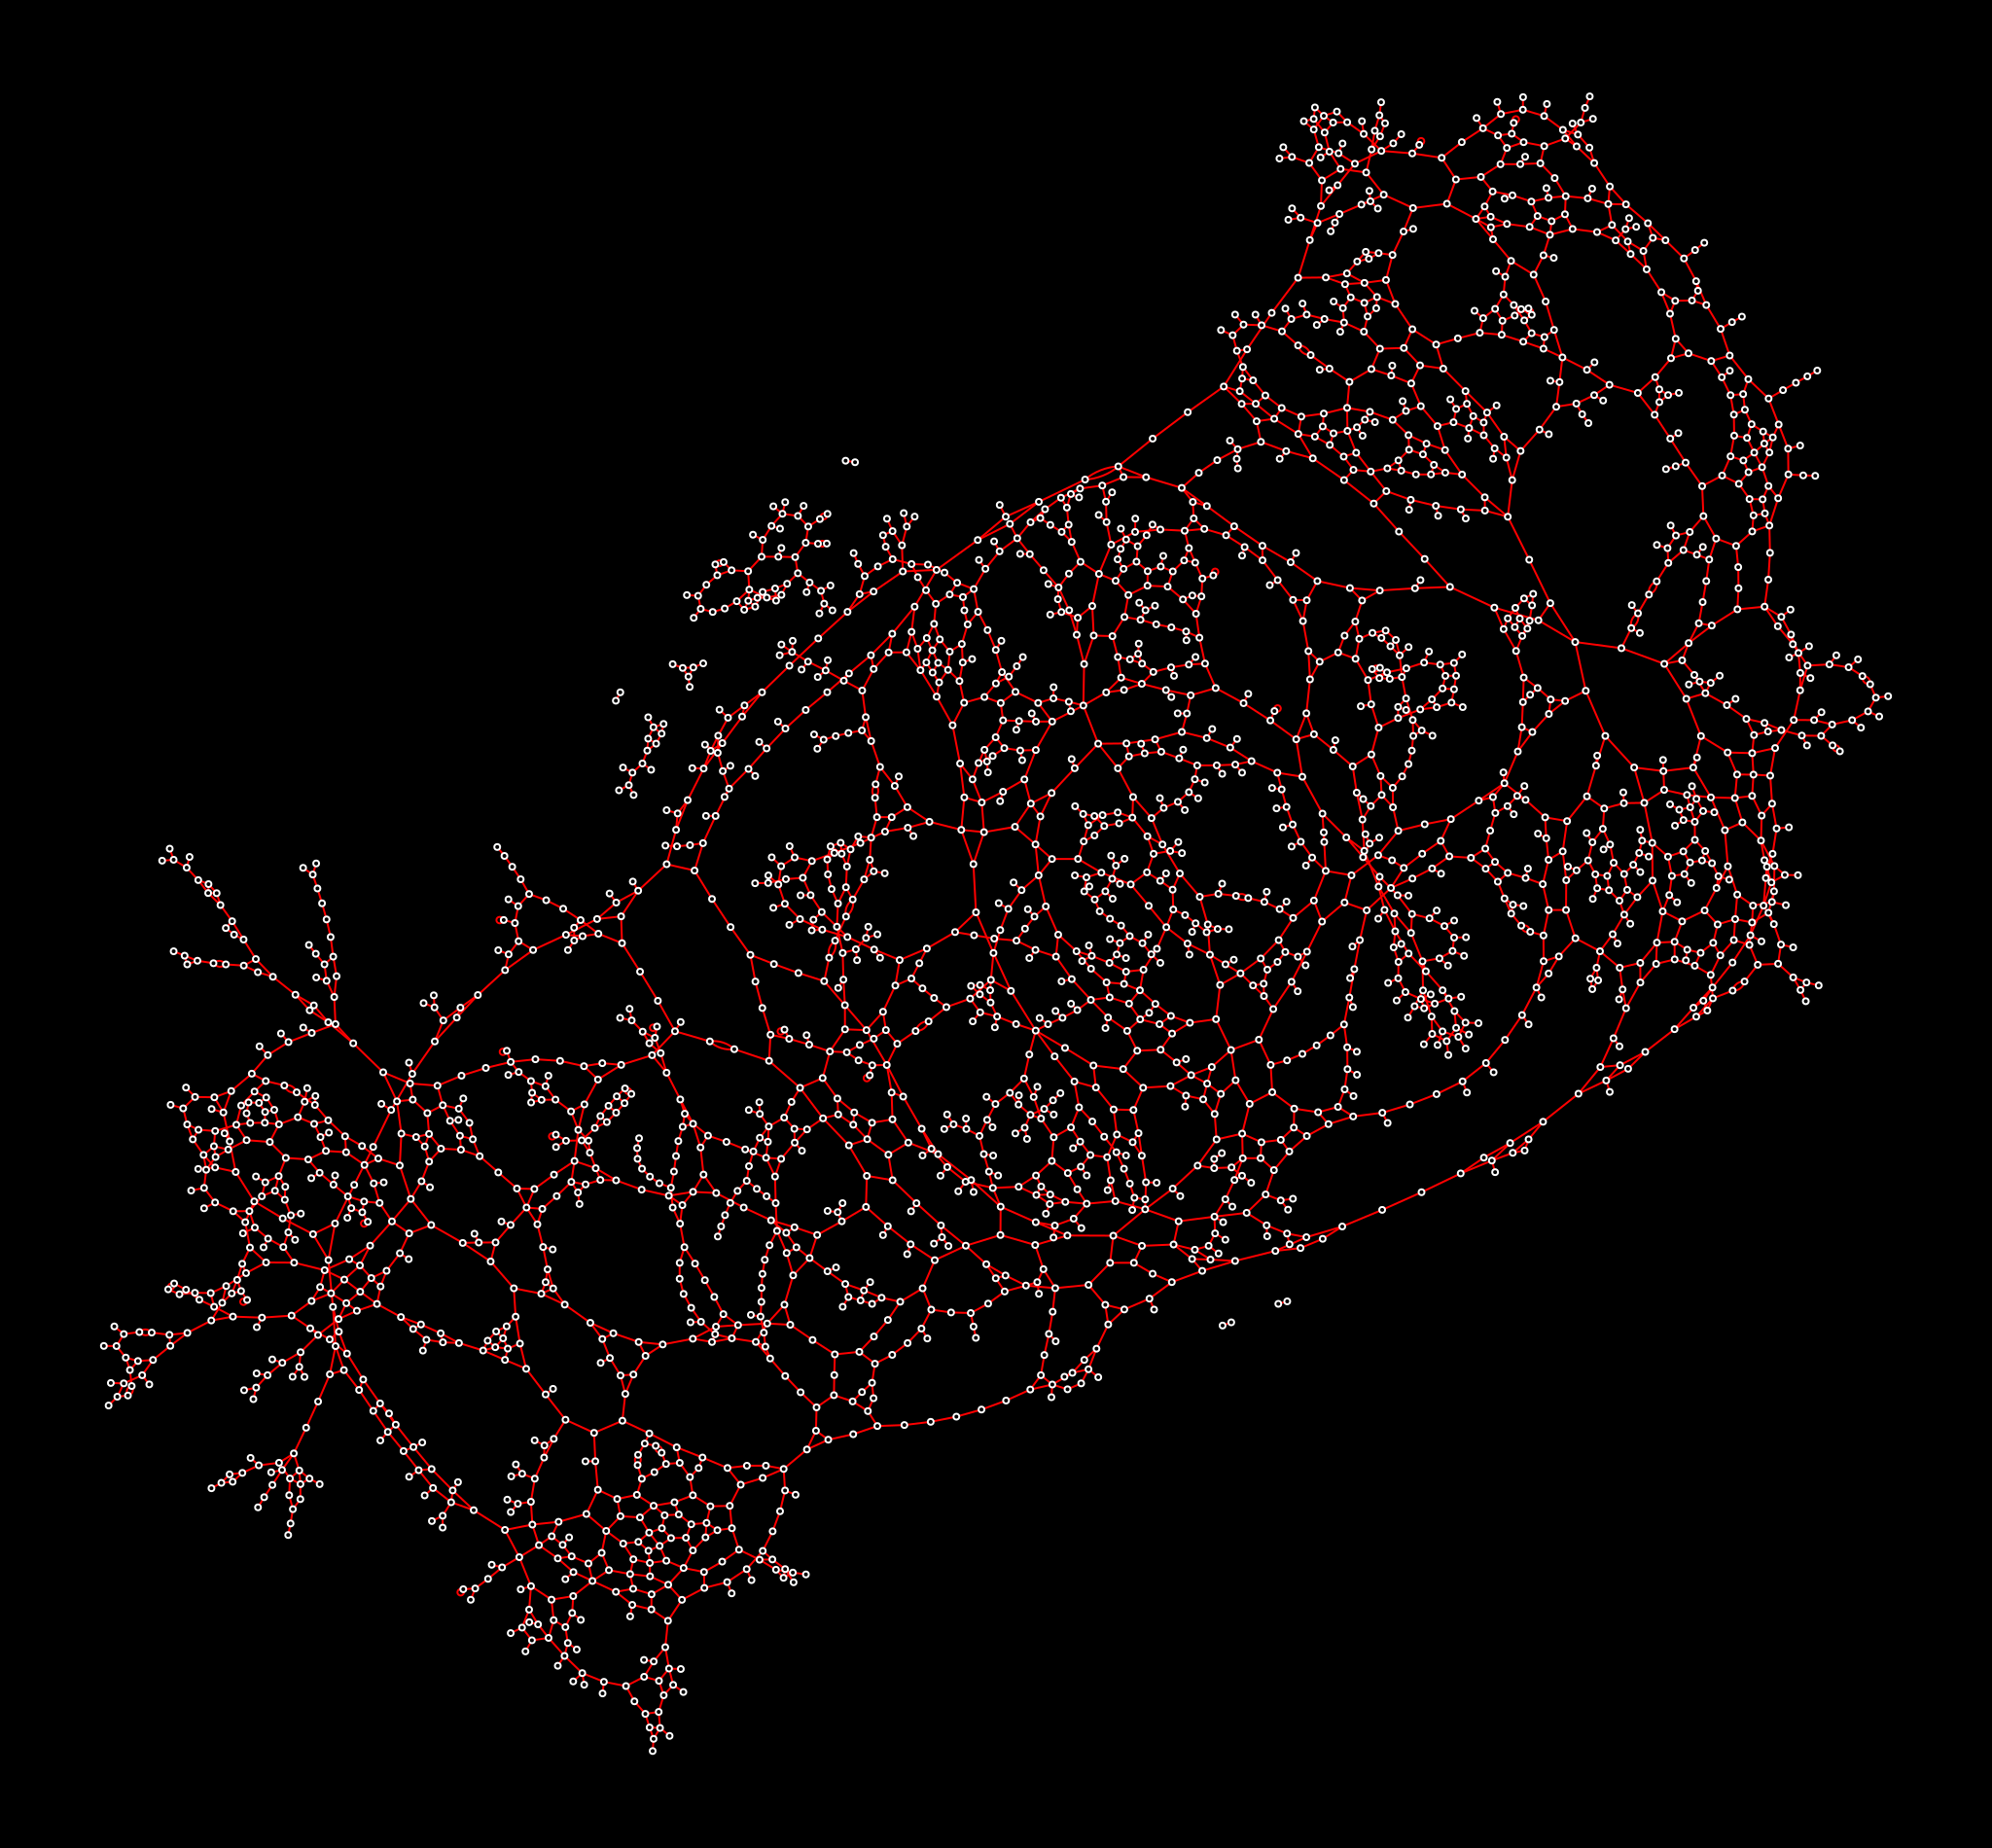

CPU times: user 12.2 s, sys: 227 ms, total: 12.5 s
Wall time: 7.06 s


In [5]:
%%time
import graph_tool.all as gt
graph_computed = roads_from_web_found.get_graph()

graph_computed.plot()


# Try a shortest path and display it

In [6]:
%%time
start_node = pois[pois['uuid'] == 47].iloc[0]["geometry"].wkt
end_node = pois[pois['uuid'] == 63].iloc[0]["geometry"].wkt

source_vertex = graph_computed.find_vertex_from_name(start_node)
target_vertex = graph_computed.find_vertex_from_name(end_node)

path_vertices, path_edges = shortest_path(
    graph_computed,
    source=source_vertex,
    target=target_vertex,
    weights=graph_computed.edge_weights
)

path_ids = [
    graph_computed.edge_names[edge]
    for edge in path_edges
]

shortest_path = roads_gdf.copy(deep=True)
shortest_path = linemerge(shortest_path[shortest_path['uuid'].isin(path_ids)].to_crs(3857)['geometry'].to_list())
shortest_path = gpd.GeoDataFrame(index=[0], crs="EPSG:3857", geometry=[shortest_path])

layers_to_add = [
    {
        "input_gdf": shortest_path,
        "legend": "shortest_path",
        "color": "red",
        "line_width": 5
    },

]

my_shortest_path_map = EasyMapBokeh(
    "My roads and POIs",
    layers=layers_to_add
)
show(my_shortest_path_map.figure)

CPU times: user 146 ms, sys: 14.2 ms, total: 160 ms
Wall time: 168 ms
